# **Installation and Imports**

In [ ]:
import sys
!{sys.executable} -m pip install lightfm
!pip install git+https://github.com/microsoft/recommenders.git

  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-wn0w4wuf
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-wn0w4wuf
  Resolved https://github.com/microsoft/recommenders.git to commit c2ea583d27bb1a4d58a09a1621d5ce95672ef1dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import warnings
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k
from recommenders.models.lightfm.lightfm_utils import track_model_metrics, similar_items

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/bt4222 project/')

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

warnings.simplefilter(action='ignore', category=FutureWarning)

# **Dataset Preparation**



*   Load Dataset
*   Create new columns for each unique genre
*   Create new columns for each unique movie and reviewer



In [ ]:
df = pd.read_csv('final_dataset.csv')
df

,Movie,Reviewer,Review,Score,Sentiment_scores,overview,cast_list,crew_list,director_list,first_three_casts,unique_genres,Date,recommend
0,SENSATION,Dennis Schwartz,"A sci-fi film that made no sense, as it tells ...",0.686869,0.276348,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","['Drama', 'Romance', 'Comedy', 'Foreign']",2022-09-01,0
1,SENSATION,Carey-Ann Pawsey,A thriller that ultimately makes little to no ...,0.393939,0.334176,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","['Drama', 'Romance', 'Comedy', 'Foreign']",2022-06-01,0
2,SENSATION,Rob Rector,"There's still much to admire with Sensation, d...",0.595960,0.739928,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","['Drama', 'Romance', 'Comedy', 'Foreign']",2021-05-19,0
3,SENSATION,Rich Cline,There's no thematic depth in the story or char...,0.494949,0.349340,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","['Drama', 'Romance', 'Comedy', 'Foreign']",2021-04-22,0
4,SENSATION,Allen Adams,Sensation wants to be a deep movie...[but] tho...,0.393939,0.240863,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","['Drama', 'Romance', 'Comedy', 'Foreign']",2021-04-21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281866,KING OF THE GYPSIES,14,know somebody actually thought good idea take ...,0.457374,0.732902,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",['Drama'],2021-10-02,0
281867,KING OF THE GYPSIES,19,fantastic movie one personal favorite,0.762626,0.885659,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",['Drama'],2020-11-03,0
281868,KING OF THE GYPSIES,111,forgot mention sn early film james franco lol,0.415657,0.712025,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",['Drama'],2020-10-02,0
281869,KING OF THE GYPSIES,112,dude best impersonation corey feldman lost boy,0.434747,0.721579,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",['Drama'],2020-08-24,0


In [ ]:
print(df.dtypes)

Movie                 object
Reviewer              object
Review                object
Score                float64
Sentiment_scores     float64
overview              object
cast_list             object
crew_list             object
director_list         object
first_three_casts     object
unique_genres         object
Date                  object
recommend              int64
dtype: object


In [ ]:
# Preprocess genre strings to remove extra characters and leading/trailing whitespace
df['unique_genres'] = df['unique_genres'].apply(lambda x: x.strip("[]").replace("'", "").strip())

# Concatenate all genre strings into a single string
all_genres = ','.join(df['unique_genres'])

# Split the concatenated string into individual genres
individual_genres = all_genres.split(',')

# Remove empty strings from the list of individual genres
individual_genres = [genre.strip() for genre in individual_genres if genre.strip()]

# Convert the resulting list of genres into a set to get unique genres
unique_genres = set(individual_genres)

for genre in unique_genres:
  df[f'genre_{genre}'] = df['unique_genres'].apply(lambda x: 1 if genre in x else 0)

df

,Movie,Reviewer,Review,Score,Sentiment_scores,overview,cast_list,crew_list,director_list,first_three_casts,unique_genres,Date,recommend,genre_War,genre_Family,genre_Drama,genre_TV Movie,genre_Western,genre_Thriller,genre_Foreign,genre_Music,genre_Comedy,genre_Action,genre_History,genre_Crime,genre_Documentary,genre_Adventure,genre_Horror,genre_Romance,genre_Fantasy,genre_Science Fiction,genre_Mystery,genre_Animation
0,SENSATION,Dennis Schwartz,"A sci-fi film that made no sense, as it tells ...",0.686869,0.276348,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2022-09-01,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
1,SENSATION,Carey-Ann Pawsey,A thriller that ultimately makes little to no ...,0.393939,0.334176,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2022-06-01,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
2,SENSATION,Rob Rector,"There's still much to admire with Sensation, d...",0.595960,0.739928,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2021-05-19,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
3,SENSATION,Rich Cline,There's no thematic depth in the story or char...,0.494949,0.349340,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2021-04-22,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
4,SENSATION,Allen Adams,Sensation wants to be a deep movie...[but] tho...,0.393939,0.240863,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2021-04-21,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281866,KING OF THE GYPSIES,14,know somebody actually thought good idea take ...,0.457374,0.732902,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2021-10-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
281867,KING OF THE GYPSIES,19,fantastic movie one personal favorite,0.762626,0.885659,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2020-11-03,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
281868,KING OF THE GYPSIES,111,forgot mention sn early film james franco lol,0.415657,0.712025,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2020-10-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
281869,KING OF THE GYPSIES,112,dude best impersonation corey feldman lost boy,0.434747,0.721579,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2020-08-24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Remove null values
df.dropna(inplace=True)

# Remove negative scores
df = df[df['Score'] >= 0]

# Generate unique identifiers for each reviewer and movie
df['Movie_ID'], _ = pd.factorize(df['Movie'])
df['Reviewer_ID'], _ = pd.factorize(df['Reviewer'])
df

,Movie,Reviewer,Review,Score,Sentiment_scores,overview,cast_list,crew_list,director_list,first_three_casts,unique_genres,Date,recommend,genre_War,genre_Family,genre_Drama,genre_TV Movie,genre_Western,genre_Thriller,genre_Foreign,genre_Music,genre_Comedy,genre_Action,genre_History,genre_Crime,genre_Documentary,genre_Adventure,genre_Horror,genre_Romance,genre_Fantasy,genre_Science Fiction,genre_Mystery,genre_Animation,Movie_ID,Reviewer_ID
0,SENSATION,Dennis Schwartz,"A sci-fi film that made no sense, as it tells ...",0.686869,0.276348,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2022-09-01,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,SENSATION,Carey-Ann Pawsey,A thriller that ultimately makes little to no ...,0.393939,0.334176,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2022-06-01,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
2,SENSATION,Rob Rector,"There's still much to admire with Sensation, d...",0.595960,0.739928,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2021-05-19,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,2
3,SENSATION,Rich Cline,There's no thematic depth in the story or char...,0.494949,0.349340,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2021-04-22,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,3
4,SENSATION,Allen Adams,Sensation wants to be a deep movie...[but] tho...,0.393939,0.240863,Man-boy farmer Donal discovers that his father...,"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe'...",['Tom Hall'],['Tom Hall'],"['Luanne Gordon', 'Kelly Campbell', 'Owen Roe']","Drama, Romance, Comedy, Foreign",2021-04-21,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281866,KING OF THE GYPSIES,14,know somebody actually thought good idea take ...,0.457374,0.732902,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2021-10-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5195,4792
281867,KING OF THE GYPSIES,19,fantastic movie one personal favorite,0.762626,0.885659,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2020-11-03,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5195,4795
281868,KING OF THE GYPSIES,111,forgot mention sn early film james franco lol,0.415657,0.712025,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2020-10-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5195,4797
281869,KING OF THE GYPSIES,112,dude best impersonation corey feldman lost boy,0.434747,0.721579,"Zharko, leader of the Romanis in NYC, passes ...","['Sterling Hayden', 'Shelley Winters', 'Susan ...","['Frank Pierson', 'Dino De Laurentiis', 'Paul ...",['Frank Pierson'],"['Sterling Hayden', 'Shelley Winters', 'Susan ...",Drama,2020-08-24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5195,4798


# **Selecting columns for user-item matrix and item_features matrix**

User-item matrix only contains `Reviewer_ID` that represents user, `Movie_ID` that represents movie, and `Score` that represents the weights for interactions.

In [ ]:
# Selecting relevant columns (ignore review and recommend since we just want implicit feedback)
review_df = df[['Reviewer_ID', 'Movie_ID', 'Score']].copy()
print(review_df.shape)

features_df = df.copy().drop(columns=['Reviewer', 'Review', 'Score', 'overview', 'cast_list', 'crew_list', 'director_list', 'first_three_casts', 'unique_genres', 'Date', 'recommend', 'Reviewer_ID'], axis=1)
print(features_df.shape)

(281871, 3)
(281871, 23)


In [ ]:
# Convert review_df and features_df to dictionaries
review_dict = review_df.to_dict(orient='records')
features_dict = features_df.to_dict(orient='records')

# **Create dataset for LightFM model input**

In [ ]:
# Initialise Dataset object
dataset = Dataset()
dataset.fit((x['Reviewer_ID'] for x in review_dict),
            (x['Movie_ID'] for x in review_dict))

# Register additional item features
dataset.fit_partial(item_features=(feature for feature in features_dict[0].keys() if feature not in ['Movie', 'Movie_ID']))

num_users, num_movies = dataset.interactions_shape()
print(f"No. of users: {num_users}")
print(f"No. of movies: {num_movies}")

No. of users: 4804
No. of movies: 5216


In [ ]:
print(features_dict[0])

{'Movie': 'SENSATION', 'Sentiment_scores': 0.2763483799221554, 'genre_War': 0, 'genre_Family': 0, 'genre_Drama': 1, 'genre_TV Movie': 0, 'genre_Western': 0, 'genre_Thriller': 0, 'genre_Foreign': 1, 'genre_Music': 0, 'genre_Comedy': 1, 'genre_Action': 0, 'genre_History': 0, 'genre_Crime': 0, 'genre_Documentary': 0, 'genre_Adventure': 0, 'genre_Horror': 0, 'genre_Romance': 1, 'genre_Fantasy': 0, 'genre_Science Fiction': 0, 'genre_Mystery': 0, 'genre_Animation': 0, 'Movie_ID': 0}


In [ ]:
# Build item features
item_features = dataset.build_item_features(
    ((row['Movie_ID'], [key for key, value in row.items() if key not in ['Movie', 'Movie_ID'] and value == 1]) for row in features_dict)
)
print(repr(item_features))

<5216x5237 sparse matrix of type '<class 'numpy.float32'>'
	with 16311 stored elements in Compressed Sparse Row format>


In [ ]:
# Build interaction matrix with weights as scores
(interactions, weights) = dataset.build_interactions(
    ((row['Reviewer_ID'], row['Movie_ID'], row['Score']) for _, row in review_df.iterrows())
)
print(repr(interactions))
print(repr(weights))

<4804x5216 sparse matrix of type '<class 'numpy.int32'>'
	with 281871 stored elements in COOrdinate format>
<4804x5216 sparse matrix of type '<class 'numpy.float32'>'
	with 281871 stored elements in COOrdinate format>


# **Split into train and test interactions**

For a LightFM model, train and test sets are expected to have the same dimensions. Convolutional train test split will not work. Hence we decide to do a chronological train test split. Train:test ratio = 85:15 (standardized across all models)

In [ ]:
# Split into train test interactions based on chronological order
df_sorted = df.sort_values(by='Date')

# Identify the index to split the data
split_index = int(len(df_sorted) * 0.85)

# Find the index of the last interaction in the training set
last_train_interaction_index = df_sorted.iloc[split_index - 1].name

# Split data into train and test sets
train_df = df_sorted.iloc[:last_train_interaction_index + 1]
test_df = df_sorted.iloc[last_train_interaction_index + 1:]

# Check for overlapping interactions
overlap_indices = train_df.index.intersection(test_df.index)
if not overlap_indices.empty:
    print("Warning: Overlapping interactions found between train and test sets.")
    print("Overlapping indices:", overlap_indices)

(train_interactions, _) = dataset.build_interactions(((x['Reviewer_ID'], x['Movie_ID'], x['Score']) for _, x in train_df.iterrows()))
(test_interactions, _) = dataset.build_interactions(((x['Reviewer_ID'], x['Movie_ID'], x['Score']) for _, x in test_df.iterrows()))

# Find overlapping interactions
overlap = test_interactions.multiply(train_interactions).tocoo()

# Remove overlapping interactions from test interactions
test_interactions = test_interactions - overlap

# **Fit the LightFM model**

## **Loss function for training: Weighted Approximate-Rank Pairwise (WARP) Loss**

The Weighted Approximate-Rank Pairwise (WRAP) loss function is well-suited for ranking-based tasks such as recommendation.

Leveraging WARP helps the model learn to rank relevant items higher than irrelevant ones, focusing on pairwise ranking of items to provide personalised recommendations.

WARP handles imbalanced data efficiently and scales well to large datasets, which yields higher Precision @ K, used mainly for top K recommendations.

In [ ]:
# Initiate LightFM model with Weighted Approximate-Rank Pairwise Loss
model = LightFM(loss='warp', no_components=30, learning_rate=0.005, item_alpha=1e-8, random_state=42)
model.fit(train_interactions, epochs=40, item_features=item_features, verbose=True)

Epoch: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


# **Model Evaluation**

## **Precision @ K = 10**

In [ ]:
precision = precision_at_k(model, test_interactions, train_interactions, item_features=item_features, k=10).mean()
precision

0.030869665

# **Recall @ K = 10**

In [ ]:
recall = recall_at_k(model, test_interactions, train_interactions, item_features=item_features, k=10).mean()
recall

0.005157419104419404

# **F-score**

In [ ]:
f_score = (2*precision*recall) / (recall+precision)
f_score

0.008838228443869021

# **Performance Table**

In [ ]:
precision_3sf = "{:.3f}".format(precision)
recall_3sf = "{:.3f}".format(recall)
f_score_3sf = "{:.3f}".format(f_score)

# Create a table to report model performance on training and testing sets
performance_table = pd.DataFrame({
    "Metric": ["Average Precision@K", "Recall@K", "F-score@K for K = 10"],
    "Overall": [precision_3sf, recall_3sf, f_score_3sf]
})

print(performance_table)

                 Metric Overall
0   Average Precision@K   0.031
1              Recall@K   0.005
2  F-score@K for K = 10   0.009


# **Evaluate model fitting process**

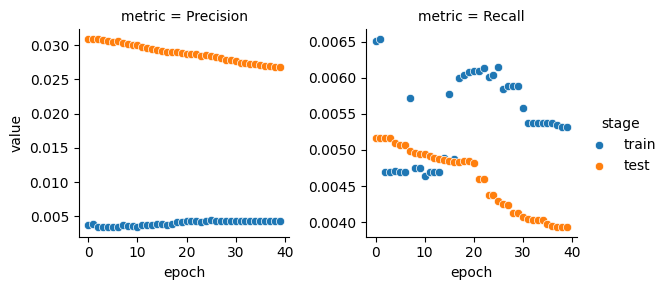

In [ ]:
output2, _ = track_model_metrics(model=model,
                                 train_interactions=train_interactions,
                                 test_interactions=test_interactions,
                                 k=10,
                                 no_epochs=40,
                                 item_features=item_features)

# **Making predictions with model**

## **Top 10 Recommended Movies for Sample User**

In [ ]:
# Return top 10 movie IDs for the particular user
def top_10_movies(model, user_id, num_movies):
  index_id = user_id - 1  # Adjust index
  scores = model.predict(index_id, np.arange(num_movies))
  top_movies_ids = np.argsort(-scores)[:10]  # select top 10 movie ids
  top_movies_df = features_df.loc[features_df['Movie_ID'].isin(top_movies_ids), ['Movie_ID', 'Movie']].drop_duplicates().head(10)
  top_movies_df.index = range(1, 11)
  print(f"For User {user_id}: ")
  return top_movies_df

In [ ]:
# Test top_10_movies function
user_id = 1  # Example user ID
top_movies_df = top_10_movies(model, user_id, num_movies)
print(top_movies_df)

For User 1: 
    Movie_ID                       Movie
1       3286                SEVEN POUNDS
2       4368                   AUSTRALIA
3       4373                        MILK
4       4941  ZACK AND MIRI MAKE A PORNO
5       5000               STEP BROTHERS
6       5025                    IRON MAN
7       5065               THE HAPPENING
8       5070                       STUCK
9       5105                   BABY MAMA
10      5202                    SEMI-PRO


## **Top 10 Similar Movies for Sample Movie**

In [ ]:
# Return top 10 similar movies to provided movie_id based on cosine similarity
def movie_top_10_movies(model, movie_id):
  movie_bias, movie_repre = model.get_item_representations(features=item_features)  # item representations for all movies
  cos_similarity = np.dot(movie_repre, movie_repre[movie_id, :])
  movie_norms = np.linalg.norm(movie_repre, axis=1)  # normalise cosine similarity
  cos_similarity /= movie_norms

  top_cos_similarity = np.argpartition(cos_similarity, -11)[-11:]  # select top 11 movies which will include given movie
  top_similar_movies = sorted(zip(top_cos_similarity, cos_similarity[top_cos_similarity]), key=lambda x: -x[1])[1:]
  top_similar_movies_index = [x[0] for x in top_similar_movies]

  movie_name = features_df.loc[features_df['Movie_ID'] == movie_id, 'Movie'].iloc[0]
  movie_names = features_df.loc[features_df['Movie_ID'].isin(top_similar_movies_index), 'Movie'].drop_duplicates().head(10)  # Filter by Movie_ID
  top_similar_movies_df = pd.DataFrame({'Movie ID': top_similar_movies_index, 'Movie Names': movie_names})

  print(f"For movie ID {movie_id}, movie name {movie_name}: ")
  return top_similar_movies_df

In [ ]:
# Test movie_top_10_movies function
movie_id = 10  # Example movie ID
top_similar_movies_df = movie_top_10_movies(model, movie_id)
print(top_similar_movies_df)

For movie ID 10, movie name BLACK FRIDAY: 
        Movie ID                                        Movie Names
18423       3495                                         THE SQUARE
67701       3587                                        FRANCOFONIA
72931       3804                           THE LAST MAN ON THE MOON
160704      2942                                   THE LOVING STORY
163878      3461                               HEMINGWAY & GELLHORN
193506      2872                       PAUL GOODMAN CHANGED MY LIFE
193539      3459  THE MAN NOBODY KNEW: IN SEARCH OF MY FATHER, C...
195174      1146                                               SKET
200311      1060                                           RESTLESS
211469       335                                          JANE EYRE


In [ ]:
movie_id = 10
similar_items(movie_id, item_features = item_features, model = model)

,itemID,score
0,3495,0.999975
1,3587,0.983292
2,3804,0.983278
3,2942,0.983053
4,3461,0.979713
5,2872,0.979709
6,3459,0.979662
7,1146,0.979578
8,1060,0.979568
9,335,0.979551
